# Stats 506, Fall 2019
## Group Project - Group 3

**Author: Wenjing Li**

**Last Update Date: Dec.11, 2019**



 This script analyzes the question:
 
**"Do people diagnosed with diabetes consume less calories in US?"**

NHANES 2015-2016 data are used in this problem.


## Import packages

In [18]:
import pandas as pd
from dfply import *
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Read data
List of XPT files from NHANES 2015-2016 that we will use in this analysis.  

DEMO_I - Demographics  

DR1TOT_I - Dietary, Day 1  

DR2TOT_I - Dietary, Day 2  

BMX_I - Body Measusrement  

DIQ_I - Diabetes

PAQ_I - Physical Activity

In [19]:
demo = pd.read_sas('../Data/DEMO_I.XPT')
dr1tot = pd.read_sas('../Data/DR1TOT_I.XPT')
dr2tot = pd.read_sas('../Data/DR2TOT_I.XPT')
bmx = pd.read_sas('../Data/BMX_I.XPT')
diq = pd.read_sas('../Data/DIQ_I.XPT')
pad = pd.read_sas('../Data/PAQ_I.XPT')

## Merge data

### Select columns needed

In [20]:
demo_new = (demo >> 
            select(X.SEQN, X.RIDAGEYR, X.RIAGENDR, X.RIDEXPRG))

dr1tot_new = (dr1tot >>
              mutate(dr1 = X.DR1TKCAL) >>
              select(X.SEQN, X.dr1))
dr2tot_new = (dr2tot >>
              mutate(dr2 = X.DR2TKCAL) >>
             select(X.SEQN, X.dr2))
dietary = pd.merge(dr1tot_new, dr2tot_new, on='SEQN', how='outer')
bmx_new = (bmx >>
          select(X.SEQN, X.BMXBMI))
diq_new = (diq >>
          select(X.SEQN, X.DIQ010))
pad_new = (pad >>
          select(X.SEQN, X.PAD615, X.PAD630, X.PAD680))
questionnaire = pd.merge(diq_new, pad_new, on='SEQN', how='outer')
merge_2 = pd.merge(bmx_new, questionnaire, on='SEQN', how='outer')
merge_3 = pd.merge(merge_2, demo_new, on='SEQN', how='outer')

### Inclusion/Exclusion

Include data with confirmed diabetes diagnosis

In [21]:
# Better to specify the values we want to include, instead of exclusion
diabetes_in = [1, 2, 3]
merge_3 = merge_3[merge_3.DIQ010.isin(diabetes_in)]

Exclude pregnant participants

In [22]:
merge_3 = merge_3[merge_3.RIDEXPRG != 1 ]

Include participants aged 12-79 years old

NHANES top-coded age at 80, which means participants aged 80 or older are all coded as 80. 

Hence, we decide to only look at adolescents greater than 12 years old) and adults less than 80 years old. 

In [23]:
merge_3 = merge_3[merge_3.RIDAGEYR < 80]
merge_3 = merge_3[merge_3.RIDAGEYR >= 12]

In [24]:
merge_3.shape

(6586, 9)

### Variable recoding/creation

Binary **diabetes** variable:

1 - diabetes or borderline

0 - non-diabetes

In [25]:
diabete = []
for i in merge_3.DIQ010:
    if i == 2:
        diabete.append(0)
    else:
        diabete.append(1)
merge_3['diabetes'] = diabete

Binary **male** variable:

1 - male

0 - female

In [26]:
male = []
for i in merge_3.RIAGENDR:
    if i == 1:
        male.append(1)
    else:
        male.append(0)
merge_3['male'] = male

Dietary intervew **day** variable: 

1 - interview day 1  

2 - interview day 2

In [27]:
merge = pd.merge(merge_3, dietary, on='SEQN', how='left')

# pivot the data into "long" format
merge = merge.melt(id_vars=merge.iloc[:,0:11], var_name='day', value_name='y')

# create a variable representing dietary interview day (1/2)
days = []
for i in merge.day:
    if i == 'dr1':
        days.append(1)
    else:
        days.append(2)
merge['day'] = days

### Prepare final working datasets

In [28]:
# remove rows with missing value
final = merge.drop(["RIDEXPRG", "RIAGENDR", "PAD615", "PAD630", "DIQ010"], axis=1)
# remove rows with any missing value
final = final.dropna()
final_day1 = final[final["day"] == 1]
final_day2 = final[final["day"] == 2]

In [29]:
final.shape

(10528, 8)

In [30]:
final_day1.shape

(5752, 8)

In [31]:
final_day2.shape

(4776, 8)

### Check normality of response variable

Day 1 Total Energy (kcal)

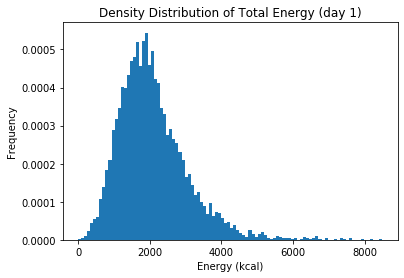

In [15]:
plt.hist(final_day1["y"], bins=100, density=1)
plt.title('Density Distribution of Total Energy (day 1)')
plt.xlabel('Energy (kcal)')
plt.ylabel('Frequency')
plt.savefig('./Figs/hist_day1.png')
plt.show()

Day 2 Total Energy (kcal)

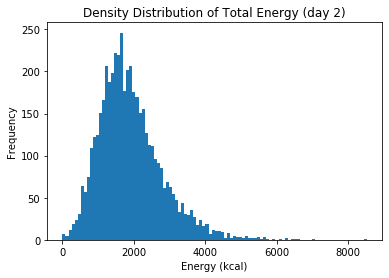

In [24]:
plt.hist(final_day2["y"], bins=100)
plt.title('Density Distribution of Total Energy (day 2)')
plt.xlabel('Energy (kcal)')
plt.ylabel('Frequency')
plt.savefig('./Figs/hist_day2.png')
plt.show()

We can also use QQ-Plot to check the normality of the response variable.

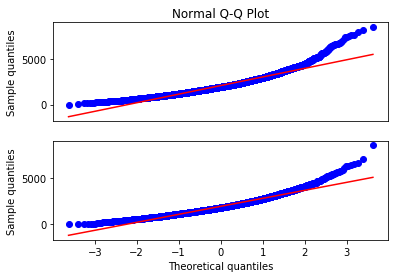

In [41]:
plt.subplot(211)
# day 1 total energy
stats.probplot(final_day1["y"], dist="norm", plot=pylab)
plt.xlabel('')
plt.ylabel('Sample quantiles')
plt.title('Normal Q-Q Plot')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.subplot(212)
# day 2 total energy
stats.probplot(final_day2["y"], dist="norm", plot=pylab)
plt.ylabel('Sample quantiles')
plt.title('')
plt.savefig('./Figs/qq_plot.png')
pylab.show()

**Conclusion**: Approximately normal - no need to transform the response variable.

### Check collinearity (use day 1 only)

Correlation matrix of predictors

In [32]:
predictors = final_day1[final_day1.columns[1:6]]
predictors.corr()

,BMXBMI,PAD680,RIDAGEYR,diabetes,male
BMXBMI,1.000000,-0.010791,0.242742,0.222468,-0.088875
PAD680,-0.010791,1.000000,-0.034440,-0.009275,-0.017472
RIDAGEYR,0.242742,-0.034440,1.000000,0.341760,-0.009280
diabetes,0.222468,-0.009275,0.341760,1.000000,0.025974
male,-0.088875,-0.017472,-0.009280,0.025974,1.000000


OLS model for day 1

In [33]:
x = sm.add_constant(final_day1[final_day1.columns[1:6]])
model = sm.OLS(final_day1['y'], x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     120.7
Date:                Thu, 12 Dec 2019   Prob (F-statistic):          8.08e-122
Time:                        00:07:27   Log-Likelihood:                -47383.
No. Observations:                5752   AIC:                         9.478e+04
Df Residuals:                    5746   BIC:                         9.482e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1845.4133     55.121     33.479      0.0

C:\Users\wenji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Variance Infation Factor (VIF)

In [34]:
# Break into left and right hand side; y and X
y, X = dmatrices("y ~ BMXBMI + PAD680 + RIDAGEYR + diabetes + male", data=final_day1, return_type="dataframe")

# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif[1:] # No need to look at VIF for intercept

[1.0980699620399632,
 1.00153717004665,
 1.172234696954212,
 1.1618062474485054,
 1.010543313776021]

**Conclusion**: No collinearity issue.

### Linear mixed model for both days

In [35]:
# LMM model
mixed = smf.mixedlm("y ~ BMXBMI + PAD680 + RIDAGEYR + diabetes + male", final, groups = final["SEQN"])
mixed_fit = mixed.fit()
#print the summary
print(mixed_fit.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  y          
No. Observations:  10528    Method:              REML       
No. Groups:        5752     Scale:               510040.7789
Min. group size:   1        Likelihood:          -86154.8654
Max. group size:   2        Converged:           Yes        
Mean group size:   1.8                                      
------------------------------------------------------------
            Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
------------------------------------------------------------
Intercept   1808.464   45.807 39.480 0.000 1718.684 1898.244
BMXBMI         2.314    1.430  1.618 0.106   -0.489    5.118
PAD680        -0.030    0.012 -2.563 0.010   -0.054   -0.007
RIDAGEYR      -2.500    0.553 -4.517 0.000   -3.584   -1.415
diabetes    -101.157   31.384 -3.223 0.001 -162.669  -39.646
male         538.477   20.178 26.686 0.000  498.928  578.025
Group Var 292948.651   22.660       

Prediction at population mean, by diabetes and gender

In [36]:
# prediction for person who has diabetes
diabetes = 1
## for man
male = 1
pre_1 = 1808.464+2.314*mean(final['BMXBMI'])-0.030*mean(final['PAD680'])-2.500*mean(final['RIDAGEYR'])- \
        101.157*diabetes+538.477*male
## for woman
male = 0
pre_2 = 1808.464+2.314*mean(final['BMXBMI'])-0.030*mean(final['PAD680'])-2.500*mean(final['RIDAGEYR'])- \
        101.157*diabetes+538.477*male

# prediction for person who doesn't have diabetes
diabetes = 0
## for man
male = 1
pre_3 = 1808.464+2.314*mean(final['BMXBMI'])-0.030*mean(final['PAD680'])-2.500*mean(final['RIDAGEYR'])- \
        101.157*diabetes+538.477*male
## for woman
male = 0
pre_4 = 1808.464+2.314*mean(final['BMXBMI'])-0.030*mean(final['PAD680'])-2.500*mean(final['RIDAGEYR'])- \
        101.157*diabetes+538.477*male

In [37]:
print('In the population mean, the estimated calorie intake for men diagnosed with diabetes is :', round(pre_1, 2),'\n' \
      'In the population mean, the estimated calorie intake for women diagnosed with diabetes is :', round(pre_2, 2),'\n' \
      'In the population mean, the estimated calorie intake for men without diabetes is :', round(pre_3, 2),'\n' \
      'In the population mean, the estimated calorie intake for women without diabetes is :', round(pre_4, 2))

In the population mean, the estimated calorie intake for men diagnosed with diabetes is : 2194.44 
In the population mean, the estimated calorie intake for women diagnosed with diabetes is : 1655.97 
In the population mean, the estimated calorie intake for men without diabetes is : 2295.6 
In the population mean, the estimated calorie intake for women without diabetes is : 1757.12
